## Exploration of Raw Dataset ##

- Determining the size of dataset throughout the years:

In [ ]:
# Imports

import pandas as pd
import numpy as np
import glob
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
import dask.dataframe as ddf
import dask.array as da
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

Converting to parquet from csv to help with speed on large datasets...

In [ ]:
# Directory containing daily files
csv_files = glob.glob('C:/com748/data/raw/daily/*.csv')

for file in csv_files:
    # Get date from file name
    date = Path(file).stem
    parquet_path = f'C:/com748/data/raw/parquet/{date}.parquet'
    file_df = pd.read_csv(file)
    table_data = pa.Table.from_pandas(file_df)
    pq.write_table(table_data, parquet_path)


Using dask to speed up analysis on large datasets

In [ ]:
# Directory containing daily files
parquet_files = glob.glob('C:/com748/data/raw/parquet/*.parquet')

rows_list = []

for file in parquet_files:
    date = Path(file).stem
    df = ddf.read_parquet(file, ignore_metadata_file=True, engine='pyarrow')

    # Daily counts
    count_hdds = df['serial_number'].nunique().compute()
    failure_count = len(df[df['failure'] == 1])


    rows_list.append({'date': date, 'total_rows': len(df.index), 'unique_hdds': count_hdds, 'total_failures': failure_count})

output_df = pd.DataFrame(data=rows_list, columns=['date', 'total_rows', 'unique_hdds', 'total_failures'])

# Write output to file
output_df.to_csv('C:/com748/code/com748/data/analysis/daily_counts.csv', index=False)


Identify failures

In [ ]:
parquet_files = glob.glob('C:/com748/data/raw/parquet/*.parquet')

dataframes_list = []

for file in parquet_files:
    date = Path(file).stem
    df = ddf.read_parquet(file, ignore_metadata_file=True, engine='pyarrow')

    # Daily failure counts
    df_failures = df[df['failure'] == 1]

    dataframes_list.append(df_failures.compute())

output_df = pd.concat(dataframes_list, ignore_index=True)

# Write output to file
output_df.to_parquet(path='C:/com748/code/com748/data/analysis/failures.parquet', engine='pyarrow', index=False)


In [ ]:
df_parquet = pd.read_parquet('C:/com748/code/com748/data/analysis/failures.parquet', engine='pyarrow')
df_parquet.to_csv('C:/com748/code/com748/data/analysis/failures.csv', index=False)

Determine manufacturer from model

In [ ]:
output_dfs = []

df_failures = pd.read_parquet('C:/com748/code/com748/data/analysis/failures.parquet', engine='pyarrow')

conditions = [
    (df_failures['model'].str.lower().str.startswith(tuple(['st', 'seagate']))),
    (df_failures['model'].str.lower().str.startswith(tuple(['toshiba']))),
    (df_failures['model'].str.lower().str.startswith(tuple(['hgst']))),
    (df_failures['model'].str.lower().str.startswith(tuple(['hitachi']))),
    (df_failures['model'].str.lower().str.startswith(tuple(['wdc'])))
]

values = ['seagate', 'toshiba', 'hgst', 'hitachi', 'wdc']

df_failures['manufacturer'] = np.select(conditions, values, default='other')

df_failures.to_csv('C:/com748/code/com748/data/analysis/failures_all_manufacturers.csv', index=False)

Smart 9 (Power on Hours) Analysis - Remove nulls

In [ ]:
df_failures = pd.read_csv('C:/com748/code/com748/data/analysis/failures_all_manufacturers.csv')

df_failures_smart_9 = df_failures[df_failures['smart_9_raw'].notna()]

df_failures_smart_9.to_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv', index=False)

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\1534158460.py:1: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.



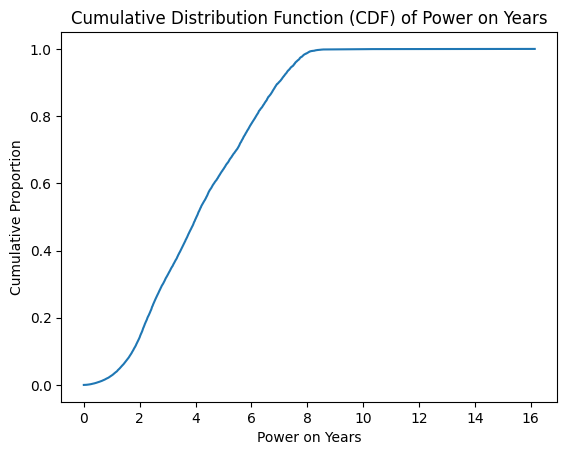

In [86]:
pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
smart_9 = df_failures_smart_9['smart_9_raw']/8760

cumulative = np.linspace(0, 1, len(smart_9))
sorted_data = np.sort(smart_9)

cumulative_data = np.cumsum(sorted_data) / np.sum(sorted_data)

# Plot the CDF
plt.plot(sorted_data, cumulative_data)

# Add labels and title
plt.xlabel("Power on Years")
plt.ylabel("Cumulative Proportion")
plt.title("Cumulative Distribution Function (CDF) of Power on Years")
plt.show()

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\3705159338.py:1: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.



(0.0, 1.05)

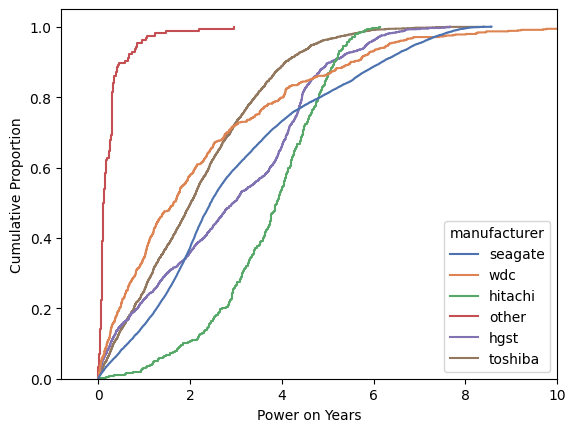

In [46]:
df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_smart_9['smart_9_raw'] = df_failures_smart_9['smart_9_raw']/8760
ecdf_plot = sns.ecdfplot(data=df_failures_smart_9, x='smart_9_raw', hue='manufacturer', palette='deep')
ecdf_plot.set(xlabel='Power on Years', ylabel='Cumulative Proportion')
ecdf_plot.set_xlim(right=10)
ecdf_plot.set_ylim((0, 1.05))

In [45]:
df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_smart_9 = df_failures_smart_9[df_failures_smart_9['manufacturer'] != 'other']
df_failures_smart_9['smart_9_raw'] = df_failures_smart_9['smart_9_raw']/8760
fig = px.ecdf(df_failures_smart_9, x="smart_9_raw", color='manufacturer', range_x=(0,10), labels=({'smart_9_raw':'Years'}), ecdfnorm='percent')
fig.show()

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\4038970187.py:1: DtypeWarning: Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.
  df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')


In [48]:
# Top 6 seagate models per failure count: ST4000DM000, ST12000NM0007, ST8000NM0055, ST3000DM001, ST12000NM0008, ST8000DM002
df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_seagate = df_failures_smart_9[df_failures_smart_9['manufacturer'] == 'seagate']
df_failures_seagate = df_failures_seagate[df_failures_seagate['model'].isin(['ST4000DM000', 'ST12000NM0007', 'ST8000NM0055', 'ST3000DM001', 'ST12000NM0008', 'ST8000DM002'])]
df_failures_seagate['smart_9_raw'] = df_failures_seagate['smart_9_raw']/8760
fig = px.ecdf(df_failures_seagate, x="smart_9_raw", color='model', range_x=(0,10), labels=({'smart_9_raw':'Years'}), ecdfnorm='percent')
fig.show()

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\4197262901.py:2: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.



C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\3651554583.py:1: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\3651554583.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



(0.0, 1.05)

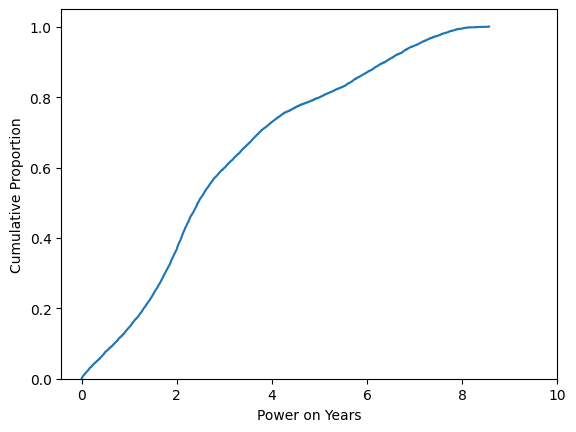

In [49]:
df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_seagate = df_failures_smart_9[df_failures_smart_9['manufacturer'] == 'seagate']
df_failures_seagate = df_failures_seagate[df_failures_seagate['model'].isin(['ST4000DM000', 'ST12000NM0007', 'ST8000NM0055', 'ST3000DM001', 'ST12000NM0008', 'ST8000DM002', 'ST14000NM001G'])]
df_failures_seagate['smart_9_raw'] = df_failures_seagate['smart_9_raw']/8760
# fig = px.ecdf(df_failures_seagate, x="smart_9_raw", color='model', range_x=(0,10), labels=({'smart_9_raw':'Years'}), ecdfnorm='percent')
ecdf_plot = sns.ecdfplot(data=df_failures_seagate, x='smart_9_raw', palette='deep')
ecdf_plot.set(xlabel='Power on Years', ylabel='Cumulative Proportion')
ecdf_plot.set_xlim(right=10)
ecdf_plot.set_ylim((0, 1.05))

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\1503043684.py:2: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.



(0.0, 1.05)

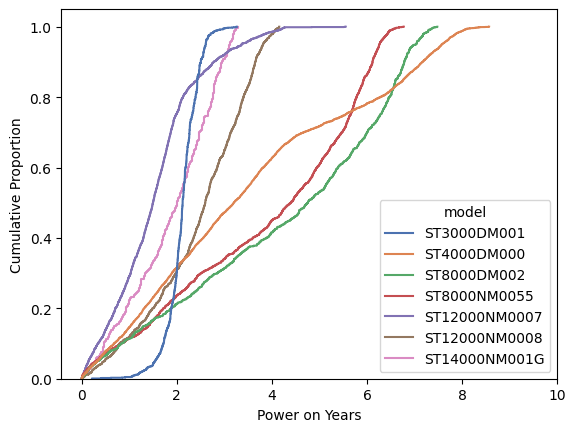

In [50]:
# Top 6 seagate models per failure count: ST4000DM000, ST12000NM0007, ST8000NM0055, ST3000DM001, ST12000NM0008, ST8000DM002
df_failures_smart_9 = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_seagate = df_failures_smart_9[df_failures_smart_9['manufacturer'] == 'seagate']
df_failures_seagate = df_failures_seagate[df_failures_seagate['model'].isin(['ST4000DM000', 'ST12000NM0007', 'ST8000NM0055', 'ST3000DM001', 'ST12000NM0008', 'ST8000DM002', 'ST14000NM001G'])]
df_failures_seagate['smart_9_raw'] = df_failures_seagate['smart_9_raw']/8760
# fig = px.ecdf(df_failures_seagate, x="smart_9_raw", color='model', range_x=(0,10), labels=({'smart_9_raw':'Years'}), ecdfnorm='percent')
ecdf_plot = sns.ecdfplot(data=df_failures_seagate, x='smart_9_raw', hue='model', palette='deep')
ecdf_plot.set(xlabel='Power on Years', ylabel='Cumulative Proportion')
ecdf_plot.set_xlim(right=10)
ecdf_plot.set_ylim((0, 1.05))
# plt.show()

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\511523089.py:1: DtypeWarning:

Columns (181,186) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\511523089.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\511523089.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



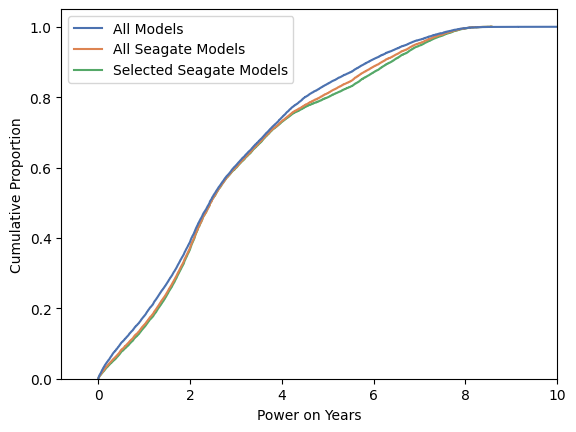

In [70]:
df_failures_all = pd.read_csv('C:/com748/code/com748/data/analysis/smart_9/failures_all_manufacturers.csv')
df_failures_all['smart_9_raw'] = df_failures_all['smart_9_raw']/8760
df_failures_all['models'] = 'All Models'

df_failures_seagate = df_failures_all[df_failures_all['manufacturer'] == 'seagate']
df_failures_seagate['models'] = 'All Seagate Models'

df_failures_selected_models = df_failures_all[df_failures_all['model'].isin(['ST4000DM000', 'ST12000NM0007', 'ST8000NM0055', 'ST3000DM001', 'ST12000NM0008', 'ST8000DM002', 'ST14000NM001G'])]
df_failures_selected_models['models'] = 'Selected Seagate Models'

df_failures_ecdf = pd.concat([df_failures_all, df_failures_seagate, df_failures_selected_models], axis=0)

ecdf_plot = sns.ecdfplot(data=df_failures_ecdf, x='smart_9_raw', hue='models', palette='deep')
ecdf_plot.set(xlabel='Power on Years', ylabel='Cumulative Proportion')
ecdf_plot.set_xlim(right=10)
ecdf_plot.set_ylim((0, 1.05))
ecdf_plot.legend_.set_title(None)

Measure number of unique HDDs in dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

parquet_files = glob.glob('C:/com748/data/raw/parquet/*.parquet')

serial_number_list = np.array([])

for file in parquet_files:
    
    date = Path(file).stem
    df = ddf.read_parquet(file, ignore_metadata_file=True, engine='pyarrow')
    df = df['serial_number'].dropna()
    serial_numbers = df.to_dask_array().compute()

    print(date)
    serial_number_list = np.unique(np.concatenate((serial_number_list, serial_numbers.tolist()), 0))

np.save('C:/com748/code/com748/data/analysis/unique_hdds.npy', serial_number_list)



In [ ]:
hdds = np.load('C:/com748/code/com748/data/analysis/unique_hdds.npy')

print(hdds)

Total Rows in Datasets

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pyarrow.parquet as pq

parquet_files = glob.glob('C:/com748/data/raw/parquet/*.parquet')

total_count = 0

for file in parquet_files:
    
    date = Path(file).stem
    parquet_file = pq.ParquetFile(file)

    row_count = parquet_file.scan_contents()
    total_count += row_count

    print(date)

print(f'Total Number of Rows in Datasets: {total_count}')

Failure Counts per Manufacturer

In [ ]:
df_failures = pd.read_csv('C:/com748/code/com748/data/analysis/failures_all_manufacturers.csv')

count_seagate = 0
count_toshiba = 0
count_hitachi = 0
count_wdc = 0
count_hgst = 0
count_other = 0

df_seagate = df_failures[df_failures['manufacturer'] == 'seagate']
df_toshiba = df_failures[df_failures['manufacturer'] == 'toshiba']
df_hitachi = df_failures[df_failures['manufacturer'] == 'hitachi']
df_wdc = df_failures[df_failures['manufacturer'] == 'wdc']
df_hgst = df_failures[df_failures['manufacturer'] == 'hgst']
df_other = df_failures[df_failures['manufacturer'] == 'other']

count_seagate = len(df_seagate.index)
count_toshiba = len(df_toshiba.index)
count_hitachi = len(df_hitachi.index)
count_wdc = len(df_wdc.index)
count_hgst = len(df_hgst.index)
count_other = len(df_other.index)

print(f'seagate: {count_seagate}, toshiba: {count_toshiba}, hitachi: {count_hitachi}, wdc: {count_wdc}, hgst: {count_hgst}, other: {count_other}')

Total Counts per Manaufacturer

In [ ]:
# Directory containing daily files
parquet_files = glob.glob('C:/com748/data/raw/parquet/*.parquet')

for file in parquet_files:
    
    date = Path(file).stem
    print(date)
    df = pd.read_parquet(path=file, columns=['date', 'model', 'serial_number', 'failure'], engine='pyarrow')

    conditions = [
    (df['model'].str.lower().str.startswith(tuple(['st', 'seagate']))),
    (df['model'].str.lower().str.startswith(tuple(['toshiba']))),
    (df['model'].str.lower().str.startswith(tuple(['hgst']))),
    (df['model'].str.lower().str.startswith(tuple(['hitachi']))),
    (df['model'].str.lower().str.startswith(tuple(['wdc'])))
    ]

    values = ['seagate', 'toshiba', 'hgst', 'hitachi', 'wdc']

    df['manufacturer'] = np.select(conditions, values, default='other')

    table_data = pa.Table.from_pandas(df)
    parquet_path = f'C:/com748/data/analysis/manufacturer_model_counts/{date}.parquet'
    pq.write_table(table_data, parquet_path)    


Manufacturer counts

In [ ]:
# Directory containing daily files
parquet_files = glob.glob('C:/com748/data/analysis/manufacturer_model_counts/*.parquet')

overall_df = pd.DataFrame(columns=['serial_number', 'manufacturer'])

for file in parquet_files:
    date = Path(file).stem
    print(date)
    df = pd.read_parquet(path=file, columns=['serial_number', 'manufacturer'], engine='pyarrow')

    overall_df = pd.concat([overall_df, df], axis=0).drop_duplicates().reset_index(drop=True)

overall_df.to_csv('C:/com748/data/analysis/manufacturer_model_counts/full_list_hdds_by_manufacturer.csv', index=False)

Model Failure Analysis

In [ ]:
# Directory containing daily files
parquet_files = glob.glob('C:/com748/data/analysis/manufacturer_model_counts/*.parquet')

overall_df = pd.DataFrame(columns=['serial_number', 'model'])

for file in parquet_files:
    date = Path(file).stem
    print(date)
    df = pd.read_parquet(path=file, columns=['serial_number', 'model'], engine='pyarrow')

    overall_df = pd.concat([overall_df, df], axis=0).drop_duplicates().reset_index(drop=True)

overall_df.to_csv('C:/com748/data/analysis/manufacturer_model_counts/full_list_hdds_by_model.csv', index=False)

In [ ]:
# Convert to parquet
df = pd.read_csv('C:/com748/data/analysis/manufacturer_model_counts/full_list_hdds_by_model.csv')

table_data = pa.Table.from_pandas(df)
parquet_path = f'C:/com748/data/analysis/manufacturer_model_counts/full_list_hdds_by_model.parquet'
pq.write_table(table_data, parquet_path)  

Select Seagate Models only:

Smart 240 (Head Flying Hours) Analysis - Remove nulls

In [ ]:
df_failures = pd.read_csv('C:/com748/code/com748/data/analysis/failures_all_manufacturers.csv')

df_failures = df_failures[df_failures['model'].isin(['ST4000DM000', 'ST12000NM0007', 'ST8000NM0055', 'ST3000DM001', 'ST12000NM0008', 'ST8000DM002', 'ST14000NM001G']) ]

df_failures.to_csv('C:/com748/code/com748/data/analysis/selected_models/failures.csv', index=False)

C:\Users\ali_m\AppData\Local\Temp\ipykernel_13424\2717450343.py:12: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



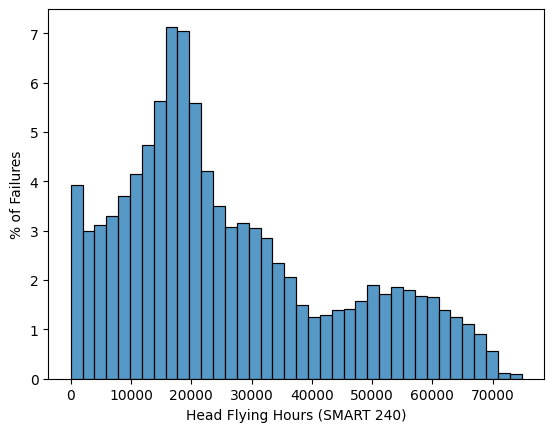

In [54]:
df_failures = pd.read_csv('C:/com748/code/com748/data/analysis/selected_models/failures.csv', usecols=['date', 'model','smart_9_raw', 'smart_240_raw'])

df_failures['hex'] = df_failures['smart_240_raw'][df_failures['smart_240_raw'].notna()].astype(int).apply(hex)
df_failures['smart_240_hours'] = df_failures['hex'].dropna().astype(str).apply(
    lambda x: 
        int('0x' + x.replace('0x', '')[-4:], 16) if len(x) > 7
        else int(x, 16)
    )

df_failures_smart_240_column = df_failures['smart_240_hours']

hist = sns.histplot(data=df_failures, x='smart_240_hours', palette='deep', stat='percent', kde=False).set(xlabel='Head Flying Hours (SMART 240)', ylabel='% of Failures')

# sns.kdeplot(data=df_failures, x='smart_240_hours', palette='deep')

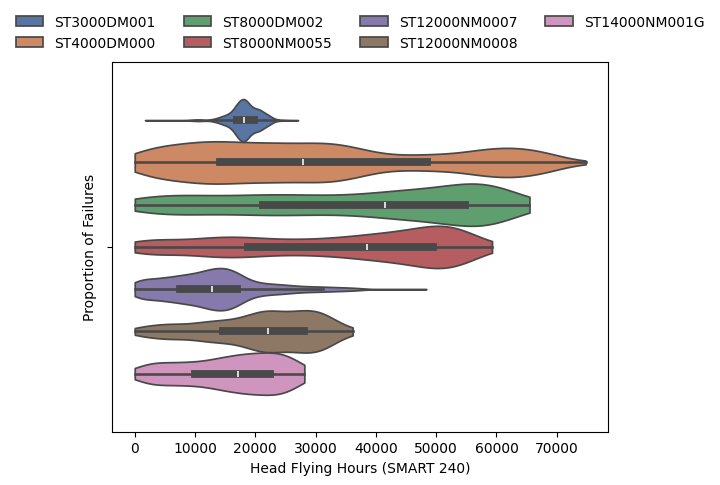

In [85]:
df_failures = pd.read_csv('C:/com748/code/com748/data/analysis/selected_models/failures.csv', usecols=['date', 'model','smart_9_raw', 'smart_240_raw'])

df_failures['hex'] = df_failures['smart_240_raw'][df_failures['smart_240_raw'].notna()].astype(int).apply(hex)
df_failures['smart_240_hours'] = df_failures['hex'].dropna().astype(str).apply(
    lambda x: 
        int('0x' + x.replace('0x', '')[-4:], 16) if len(x) > 7
        else int(x, 16)
    )

df_failures_smart_240_column = df_failures['smart_240_hours']

hist = sns.violinplot(data=df_failures, x='smart_240_hours', palette='deep', cut=0, hue='model').set(xlabel='Head Flying Hours (SMART 240)', ylabel='Proportion of Failures')
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=4, frameon=False)